In [5]:
#import xgboost as xgb
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
import os
import matplotlib.pyplot as plt
import json
import scipy.stats as stats
import nfl_data_py as nfl

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
from torchsummary import summary
from skorch import NeuralNetRegressor

ModuleNotFoundError: No module named 'nfl_data_py'

In [2]:
# Pull season-level data

year_range = list(range(2000,2025))
season_df = nfl.import_seasonal_data(year_range, s_type='REG')

In [3]:
season_cols = ['player_id', 'season', 'completions', 'attempts',
       'passing_yards', 'passing_tds', 'interceptions', 'sacks', 'sack_yards',
       'sack_fumbles', 'sack_fumbles_lost', 'passing_air_yards',
       'passing_yards_after_catch', 'passing_first_downs', 'passing_epa',
       'passing_2pt_conversions', 'pacr', 'dakota', 'carries', 'rushing_yards',
       'rushing_tds', 'rushing_fumbles', 'rushing_fumbles_lost',
       'rushing_first_downs', 'rushing_epa', 'rushing_2pt_conversions',
       'receptions', 'targets', 'receiving_yards', 'receiving_tds',
       'receiving_fumbles', 'receiving_fumbles_lost', 'receiving_air_yards',
       'receiving_yards_after_catch', 'receiving_first_downs', 'receiving_epa',
       'receiving_2pt_conversions', 'racr', 'target_share', 'air_yards_share',
       'wopr_x', 'special_teams_tds', 'fantasy_points', 'fantasy_points_ppr',
       'games', 'tgt_sh', 'ay_sh', 'yac_sh', 'wopr_y', 'ry_sh', 'rtd_sh',
       'rfd_sh', 'rtdfd_sh', 'dom', 'w8dom', 'yptmpa', 'ppr_sh']

season_df = season_df[season_cols]

In [4]:
season_df.columns

Index(['player_id', 'season', 'completions', 'attempts', 'passing_yards',
       'passing_tds', 'interceptions', 'sacks', 'sack_yards', 'sack_fumbles',
       'sack_fumbles_lost', 'passing_air_yards', 'passing_yards_after_catch',
       'passing_first_downs', 'passing_epa', 'passing_2pt_conversions', 'pacr',
       'dakota', 'carries', 'rushing_yards', 'rushing_tds', 'rushing_fumbles',
       'rushing_fumbles_lost', 'rushing_first_downs', 'rushing_epa',
       'rushing_2pt_conversions', 'receptions', 'targets', 'receiving_yards',
       'receiving_tds', 'receiving_fumbles', 'receiving_fumbles_lost',
       'receiving_air_yards', 'receiving_yards_after_catch',
       'receiving_first_downs', 'receiving_epa', 'receiving_2pt_conversions',
       'racr', 'target_share', 'air_yards_share', 'wopr_x',
       'special_teams_tds', 'fantasy_points', 'fantasy_points_ppr', 'games',
       'tgt_sh', 'ay_sh', 'yac_sh', 'wopr_y', 'ry_sh', 'rtd_sh', 'rfd_sh',
       'rtdfd_sh', 'dom', 'w8dom', 'yptmpa

In [5]:
season_df.sort_values('season').head()

,player_id,season,completions,attempts,passing_yards,passing_tds,interceptions,sacks,sack_yards,sack_fumbles,...,yac_sh,wopr_y,ry_sh,rtd_sh,rfd_sh,rtdfd_sh,dom,w8dom,yptmpa,ppr_sh
0,00-0000003,2000,0,0,0.0,0,0.0,0.0,0.0,0,...,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.002418
1106,00-0008962,2000,0,0,0.0,0,0.0,0.0,0.0,0,...,NaN,NaN,0.102874,0.062500,0.117241,0.111801,0.082687,0.094800,0.685139,0.058670
1114,00-0009007,2000,55,114,506.0,2,5.0,8.0,60.0,1,...,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.060457
1116,00-0009038,2000,0,0,0.0,0,0.0,0.0,0.0,0,...,NaN,NaN,0.042660,0.045455,0.053333,0.052326,0.044057,0.043219,0.303828,0.066606
1117,00-0009119,2000,0,0,0.0,0,0.0,0.0,0.0,0,...,NaN,NaN,0.112322,0.142857,0.095238,0.099379,0.127590,0.118429,0.714286,0.080079


In [6]:
players = nfl.import_players()

In [7]:
positions = ['QB', 'RB', 'WR', 'TE']
skill_df = players[players['position'].isin(positions)].copy()
skill_df = skill_df[skill_df['status'] == 'ACT']

In [8]:
player_cols = ['position', 'gsis_id',
       'display_name', 'rookie_year', 'college_conference',
       'draft_number', 'status', 'team_abbr', 'height', 'weight', 'college_name',
       'years_of_experience', 'birth_date', 'team_seq']

skill_df = skill_df[player_cols]

In [9]:
skill_df.columns

Index(['position', 'gsis_id', 'display_name', 'rookie_year',
       'college_conference', 'draft_number', 'status', 'team_abbr', 'height',
       'weight', 'college_name', 'years_of_experience', 'birth_date',
       'team_seq'],
      dtype='object')

In [10]:
skill_df.head()

,position,gsis_id,display_name,rookie_year,college_conference,draft_number,status,team_abbr,height,weight,college_name,years_of_experience,birth_date,team_seq
3,TE,00-0039793,A.J. Barner,2024.0,Big Ten Conference,121.0,ACT,SEA,78.0,251.0,Michigan,0,2002-05-03,NaN
5,WR,00-0035676,A.J. Brown,2019.0,Southeastern Conference,51.0,ACT,PHI,72.0,226.0,Mississippi,6,1997-06-30,1.0
13,RB,00-0036265,A.J. Dillon,2020.0,Atlantic Coast Conference,62.0,ACT,PHI,73.0,250.0,Boston College,5,1998-05-02,NaN
26,WR,00-0040302,A.J. Henning,2025.0,Big Ten Conference,NaN,ACT,MIA,70.0,192.0,Northwestern,None,2001-09-09,NaN
54,WR,00-0038612,A.T. Perry,2023.0,Atlantic Coast Conference,195.0,ACT,DEN,77.0,205.0,Wake Forest,2,1999-10-26,NaN


In [11]:
df = pd.merge(
    skill_df,
    season_df,
    how='inner',
    left_on='gsis_id',
    right_on='player_id',
    suffixes=('_skill', '_season')
)

In [12]:
df.head(20)

,position,gsis_id,display_name,rookie_year,college_conference,draft_number,status,team_abbr,height,weight,...,yac_sh,wopr_y,ry_sh,rtd_sh,rfd_sh,rtdfd_sh,dom,w8dom,yptmpa,ppr_sh
0,TE,00-0039793,A.J. Barner,2024.0,Big Ten Conference,121.0,ACT,SEA,78.0,251.0,...,0.089130,0.144752,0.065843,0.210526,0.098901,0.109453,0.138184,0.094779,0.489022,0.063304
1,WR,00-0035676,A.J. Brown,2019.0,Southeastern Conference,51.0,ACT,PHI,72.0,226.0,...,0.253268,0.508385,0.265672,0.275862,0.220339,0.228155,0.270767,0.267710,2.345982,0.148177
2,WR,00-0035676,A.J. Brown,2019.0,Southeastern Conference,51.0,ACT,PHI,72.0,226.0,...,0.319527,0.637482,0.329149,0.366667,0.308989,0.317308,0.347908,0.336652,2.535377,0.175839
3,WR,00-0035676,A.J. Brown,2019.0,Southeastern Conference,51.0,ACT,PHI,72.0,226.0,...,0.173304,0.704500,0.288704,0.238095,0.294118,0.287356,0.263400,0.278583,2.161692,0.158157
4,WR,00-0035676,A.J. Brown,2019.0,Southeastern Conference,51.0,ACT,PHI,72.0,226.0,...,0.271520,0.720957,0.342805,0.440000,0.302564,0.318182,0.391402,0.362244,2.791045,0.184954
5,WR,00-0035676,A.J. Brown,2019.0,Southeastern Conference,51.0,ACT,PHI,72.0,226.0,...,0.264838,0.726987,0.358003,0.291667,0.355330,0.348416,0.324835,0.344736,2.586146,0.196023
6,WR,00-0035676,A.J. Brown,2019.0,Southeastern Conference,51.0,ACT,PHI,72.0,226.0,...,0.309378,0.847344,0.415639,0.350000,0.411290,0.402778,0.382820,0.402512,3.491909,0.187299
7,RB,00-0036265,A.J. Dillon,2020.0,Atlantic Coast Conference,62.0,ACT,PHI,73.0,250.0,...,0.013687,0.011915,0.009215,0.000000,0.008130,0.006711,0.004607,0.007372,0.071186,0.041578
8,RB,00-0036265,A.J. Dillon,2020.0,Atlantic Coast Conference,62.0,ACT,PHI,73.0,250.0,...,0.128631,0.096038,0.069156,0.051282,0.063830,0.062044,0.060219,0.065581,0.527825,0.110896
9,RB,00-0036265,A.J. Dillon,2020.0,Atlantic Coast Conference,62.0,ACT,PHI,73.0,250.0,...,0.100995,0.117602,0.052956,0.000000,0.048387,0.042254,0.026478,0.042365,0.365897,0.116721


In [13]:
df.columns

Index(['position', 'gsis_id', 'display_name', 'rookie_year',
       'college_conference', 'draft_number', 'status', 'team_abbr', 'height',
       'weight', 'college_name', 'years_of_experience', 'birth_date',
       'team_seq', 'player_id', 'season', 'completions', 'attempts',
       'passing_yards', 'passing_tds', 'interceptions', 'sacks', 'sack_yards',
       'sack_fumbles', 'sack_fumbles_lost', 'passing_air_yards',
       'passing_yards_after_catch', 'passing_first_downs', 'passing_epa',
       'passing_2pt_conversions', 'pacr', 'dakota', 'carries', 'rushing_yards',
       'rushing_tds', 'rushing_fumbles', 'rushing_fumbles_lost',
       'rushing_first_downs', 'rushing_epa', 'rushing_2pt_conversions',
       'receptions', 'targets', 'receiving_yards', 'receiving_tds',
       'receiving_fumbles', 'receiving_fumbles_lost', 'receiving_air_yards',
       'receiving_yards_after_catch', 'receiving_first_downs', 'receiving_epa',
       'receiving_2pt_conversions', 'racr', 'target_share', 'a

In [14]:
df['fumbles_lost'] = df['sack_fumbles_lost'].fillna(0) + df['rushing_fumbles_lost'].fillna(0) + df['receiving_fumbles_lost'].fillna(0)

In [15]:
df.to_csv('fantasy_season_data.csv', index=False)

In [16]:
# Get current columns
cols = df.columns.tolist()

# Remove 'season' and insert it at index 3 (4th position)
cols.remove('season')
cols.insert(3, 'season')

# Reorder the DataFrame
df = df[cols]

In [17]:
df_qb = df[df['position'] == 'QB']
df_rb = df[df['position'] == 'RB']
df_wr = df[df['position'] == 'WR']
df_te = df[df['position'] == 'TE']

In [18]:
df_qb.tail(20)

,position,gsis_id,display_name,season,rookie_year,college_conference,draft_number,status,team_abbr,height,...,wopr_y,ry_sh,rtd_sh,rfd_sh,rtdfd_sh,dom,w8dom,yptmpa,ppr_sh,fumbles_lost
3085,QB,00-0028118,Tyrod Taylor,2013,2011.0,Atlantic Coast Conference,180.0,ACT,NYJ,73.0,...,0.012758,0.008889,0.000000,0.000000,0.000000,0.004444,0.007111,0.057143,0.029833,0.0
3086,QB,00-0028118,Tyrod Taylor,2014,2011.0,Atlantic Coast Conference,180.0,ACT,NYJ,73.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.002194,0.0
3087,QB,00-0028118,Tyrod Taylor,2015,2011.0,Atlantic Coast Conference,180.0,ACT,NYJ,73.0,...,0.004537,0.001316,0.000000,0.000000,0.000000,0.000658,0.001053,0.010499,0.230764,1.0
3088,QB,00-0028118,Tyrod Taylor,2016,2011.0,Atlantic Coast Conference,180.0,ACT,NYJ,73.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.210224,2.0
3089,QB,00-0028118,Tyrod Taylor,2017,2011.0,Atlantic Coast Conference,180.0,ACT,NYJ,73.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.208452,2.0
3090,QB,00-0028118,Tyrod Taylor,2018,2011.0,Atlantic Coast Conference,180.0,ACT,NYJ,73.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.118873,0.0
3091,QB,00-0028118,Tyrod Taylor,2019,2011.0,Atlantic Coast Conference,180.0,ACT,NYJ,73.0,...,0.008053,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.013699,0.0
3092,QB,00-0028118,Tyrod Taylor,2020,2011.0,Atlantic Coast Conference,180.0,ACT,NYJ,73.0,...,0.000000,0.000000,NaN,0.000000,0.000000,NaN,NaN,0.000000,0.135395,0.0
3093,QB,00-0028118,Tyrod Taylor,2021,2011.0,Atlantic Coast Conference,180.0,ACT,NYJ,73.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.207895,0.0
3094,QB,00-0028118,Tyrod Taylor,2022,2011.0,Atlantic Coast Conference,180.0,ACT,NYJ,73.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.075356,1.0


In [19]:
df_qb = df_qb.sort_values(['gsis_id', 'season'])

In [20]:
# List all relevant columns (features + targets)
cols_to_check = [
    'rookie_year', 'college_conference', 'draft_number', 'height', 'weight',
    'years_of_experience', 'team_abbr', 'season', 'status', 'attempts',
    'completions', 'carries', 'pacr', 'dakota', 'racr', 'target_share',
    'air_yards_share', 'games',
    # targets:
    'passing_yards', 'passing_tds', 'interceptions', 'rushing_yards',
    'rushing_tds', 'rushing_2pt_conversions', 'passing_2pt_conversions',
    'fumbles_lost'
]

# Check missing data counts
missing_counts = df_qb[cols_to_check].isnull().sum().sort_values(ascending=False)

print("Missing data per column:")
print(missing_counts)

# Optional: show percentage missing
missing_pct = (df_qb[cols_to_check].isnull().mean() * 100).sort_values(ascending=False)
print("\nPercentage missing per column:")
print(missing_pct)

Missing data per column:
draft_number               129
rookie_year                 34
college_conference          34
racr                         0
passing_2pt_conversions      0
rushing_2pt_conversions      0
rushing_tds                  0
rushing_yards                0
interceptions                0
passing_tds                  0
passing_yards                0
games                        0
air_yards_share              0
target_share                 0
dakota                       0
pacr                         0
carries                      0
completions                  0
attempts                     0
status                       0
season                       0
team_abbr                    0
years_of_experience          0
weight                       0
height                       0
fumbles_lost                 0
dtype: int64

Percentage missing per column:
draft_number               18.587896
rookie_year                 4.899135
college_conference          4.899135
racr         

In [21]:
# For draft_number: fill missing with a special value, e.g. -1
df_qb['draft_number'].fillna(-1, inplace=True)

# For rookie_year: fill missing with the player's earliest season in the dataset
def fill_rookie_year(row):
    if pd.isna(row['rookie_year']):
        player_seasons = df_qb[df_qb['gsis_id'] == row['gsis_id']]['season']
        if not player_seasons.empty:
            return player_seasons.min()
        else:
            return row['rookie_year']  # fallback, still NaN
    else:
        return row['rookie_year']

df_qb['rookie_year'] = df_qb.apply(fill_rookie_year, axis=1)

# For college_conference: fill missing with 'Unknown'
df_qb['college_conference'].fillna('Unknown', inplace=True)

In [22]:
# Final columns
features = [
    'rookie_year', 'college_conference', 'draft_number', 'height', 'weight',
    'years_of_experience', 'team_abbr', 'season', 'status', 'attempts',
    'completions', 'carries', 'pacr', 'dakota', 'racr', 'target_share',
    'air_yards_share', 'games',
    'sacks', 'sack_yards', 'sack_fumbles',
    'passing_air_yards', 'passing_yards_after_catch',
    'passing_first_downs', 'passing_epa', 'rushing_epa'
]


target = [
    'passing_yards', 'passing_tds', 'interceptions',
    'rushing_yards', 'rushing_tds',
    'rushing_2pt_conversions', 'passing_2pt_conversions',
    'fumbles_lost'
]

In [23]:
X = df_qb[features].copy()
y = df_qb[target].copy()

In [24]:
cat_features = ['team_abbr', 'college_conference', 'status']
num_features = [col for col in features if col not in cat_features]

# Column transformer
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
], remainder='passthrough')  # passthrough keeps the numeric columns

In [25]:
train_count = df_qb[(df_qb['season'] >= 2000) & (df_qb['season'] <= 2022)].shape[0]
val_count = df_qb[(df_qb['season'] == 2023)].shape[0]
test_count = df_qb[(df_qb['season'] == 2024)].shape[0]
total_count = train_count + val_count + test_count
train_count/total_count, val_count/total_count, test_count/total_count

(0.7881844380403458, 0.1037463976945245, 0.10806916426512968)

In [26]:
scaler = StandardScaler()

train = df_qb[df_qb['season'] <= 2022]
val = df_qb[df_qb['season'] == 2023]
test = df_qb[df_qb['season'] >= 2024]

X_train = scaler.fit_transform(preprocessor.fit_transform(train[features]))
y_train = train[target].values

X_val = scaler.transform(preprocessor.transform(val[features]))
y_val = val[target].values

X_test = scaler.transform(preprocessor.transform(test[features]))
y_test = test[target].values

In [36]:
X_train = X_train.astype(np.float32)
y_train = y_train.astype(np.float32)
X_val = X_val.astype(np.float32)
y_val = y_val.astype(np.float32)

In [37]:
# Convert to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# DataLoaders
train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=32, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val_tensor, y_val_tensor), batch_size=32)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=32)

In [38]:
class QBPerformanceModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, dropout_prob):
        super(QBPerformanceModel, self).__init__()
        
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_prob),
            
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_prob),
            
            nn.Linear(hidden_dim, 8)  # 7 targets: yds, TDs, ints, etc.
        )

    def forward(self, x):
        return self.model(x)

In [39]:
input_dim = X_train_tensor.shape[1]
output_dim = y_train_tensor.shape[1]
hidden_dim = 256
dropout_prob = 0.3

model = QBPerformanceModel(input_dim=input_dim, hidden_dim=hidden_dim, dropout_prob=dropout_prob)

In [40]:
net = NeuralNetRegressor(
    QBPerformanceModel,
    module__input_dim=input_dim,
    module__hidden_dim=256,
    module__dropout_prob=0.3,
    max_epochs=20,
    lr=0.001,
    iterator_train__shuffle=True,
    device='cuda' if torch.cuda.is_available() else 'cpu'
)

In [41]:
param_dist = {
    'lr': stats.loguniform(1e-4, 1e-2),
    'module__hidden_dim': [64, 128, 256],
    'module__dropout_prob': [0.1, 0.3, 0.5],
    'max_epochs': [10, 20, 30]
}

In [45]:
random_search = RandomizedSearchCV(
    net,
    param_distributions=param_dist,
    n_iter=10,
    cv=3,
    scoring='neg_mean_squared_error',
    verbose=2,
    error_score='raise'  # <-- raises error instead of silently converting to nan
)
random_search.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1   824334.5668   827826.1875  0.0912
      2   823640.7872   826571.1250  0.0088
      3   821187.6555   817614.6875  0.0039
      4   775524.0436   182347.5000  0.0081
      5   771048.7199   831944.6250  0.0053
      6   830066.1050   827876.3125  0.0063
      7   825766.3366   818377.2500  0.0038
      8   821539.3033   827410.3750  0.0045
      9   823586.5511   822131.0000  0.0034
     10   822486.4289   820783.3125  0.0050
     11   821430.2517   824291.2500  0.0047
     12   820730.8462   818288.6875  0.0034
     13   821244.8905   822750.6875  0.0063
     14   820615.8217   824783.5625  0.0042
     15   820318.8720   816689.1250  0.0041
     16   821973.9624   823591.0000  0.0061
     17   819410.7837   822064.9375  0.0043
     18   817826.1109   823160.5000  0.0049
     19   818206.4334   863416.6250  0.0090
     20   86065

ValueError: Input contains NaN.

In [195]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [196]:
n_epochs = 500
patience = 7
save_path = "best_model.pth"
val_score_file = "best_val_loss.txt"

best_val_loss_current_run = float('inf')
epochs_no_improve = 0
best_model_state_dict = None

for epoch in range(1, n_epochs + 1):
    model.train()
    train_loss = 0.0
    train_batches = 0
    for batch in train_loader:
        optimizer.zero_grad()
        inputs, targets = batch
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_batches += 1
    train_loss /= train_batches

    model.eval()
    val_loss = 0.0
    val_batches = 0
    with torch.no_grad():
        for batch in val_loader:
            inputs, targets = batch
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()
            val_batches += 1
    val_loss /= val_batches

    print(f"Epoch {epoch}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    if val_loss < best_val_loss_current_run:
        best_val_loss_current_run = val_loss
        best_model_state_dict = model.state_dict()
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= patience:
        print(f"Early stopping triggered after {epoch} epochs with no improvement in current run.")
        break

previous_best_val_loss = float('inf')
if os.path.exists(val_score_file):
    with open(val_score_file, "r") as f:
        previous_best_val_loss = float(f.read().strip())
    print(f"Previous best val loss: {previous_best_val_loss:.4f}")

if best_model_state_dict is not None and best_val_loss_current_run < previous_best_val_loss:
    print(f"New overall best model! Saving model with val loss {best_val_loss_current_run:.4f}")

    hyperparams = {
        "input_dim": input_dim,
        "hidden_dim": hidden_dim,
        "dropout_prob": dropout_prob
    }

    with open("best_model_params.json", "w") as f:
        json.dump(hyperparams, f)

    torch.save(best_model_state_dict, save_path)

    with open(val_score_file, "w") as f:
        f.write(f"{best_val_loss_current_run}")
else:
    print(f"Current run val loss {best_val_loss_current_run:.4f} did not beat previous best {previous_best_val_loss:.4f}. Not saving.")

Epoch 1, Train Loss: 935914.9670, Val Loss: 622983.1875
Epoch 2, Train Loss: 927346.6458, Val Loss: 611396.6250
Epoch 3, Train Loss: 904164.6944, Val Loss: 582247.6562
Epoch 4, Train Loss: 815546.2205, Val Loss: 523789.8958
Epoch 5, Train Loss: 669311.8646, Val Loss: 430546.5417
Epoch 6, Train Loss: 433770.0434, Val Loss: 307352.9271
Epoch 7, Train Loss: 208445.2752, Val Loss: 205754.1172
Epoch 8, Train Loss: 104391.9894, Val Loss: 158444.3203
Epoch 9, Train Loss: 86711.3928, Val Loss: 147741.8021
Epoch 10, Train Loss: 76288.0959, Val Loss: 142461.3125
Epoch 11, Train Loss: 71758.3685, Val Loss: 134725.7552
Epoch 12, Train Loss: 68134.5612, Val Loss: 127267.1562
Epoch 13, Train Loss: 69674.9891, Val Loss: 121635.2656
Epoch 14, Train Loss: 59396.2612, Val Loss: 117390.9557
Epoch 15, Train Loss: 56893.9414, Val Loss: 113429.7109
Epoch 16, Train Loss: 53147.5078, Val Loss: 111057.1224
Epoch 17, Train Loss: 51833.4438, Val Loss: 103946.4935
Epoch 18, Train Loss: 45604.5993, Val Loss: 10184

model = QBPerformanceModel(input_dim=input_dim, hidden_dim=hidden_dim, dropout_prob=dropout_prob)
model.load_state_dict(torch.load("best_model.pth"))
model.eval()

trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Trainable parameters: {trainable_params}")

In [197]:
summary(model, input_size=(input_dim,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 256]          18,688
              ReLU-2                  [-1, 256]               0
           Dropout-3                  [-1, 256]               0
            Linear-4                  [-1, 256]          65,792
              ReLU-5                  [-1, 256]               0
           Dropout-6                  [-1, 256]               0
            Linear-7                    [-1, 8]           2,056
Total params: 86,536
Trainable params: 86,536
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.33
Estimated Total Size (MB): 0.34
----------------------------------------------------------------


In [198]:
#Reload
#model = QBPerformanceModel(input_dim, output_dim)
#model.load_state_dict(torch.load("qb_model.pth"))
#model.eval()

In [199]:
model.eval()
with torch.no_grad():
    preds = model(X_val_tensor)
    mse = criterion(preds, y_val_tensor).item()
    print(f"Final MSE on validation set: {mse:.2f}")

Final MSE on validation set: 76198.92


In [200]:
actual_vs_pred = pd.DataFrame({
    'Actual': y_val_tensor[:, 0].numpy(),
    'Predicted': preds[:, 0].numpy()
})

print(actual_vs_pred.sample(10))  # See random comparisons

    Actual    Predicted
51  2562.0  2451.454834
70  4108.0  2992.490723
62   859.0   835.660278
28    74.0   631.430298
44  4624.0  4111.898926
61    37.0    51.050545
4    185.0   241.661621
57  2070.0  2063.160889
32  3678.0  3298.068848
14  1205.0  1118.791260


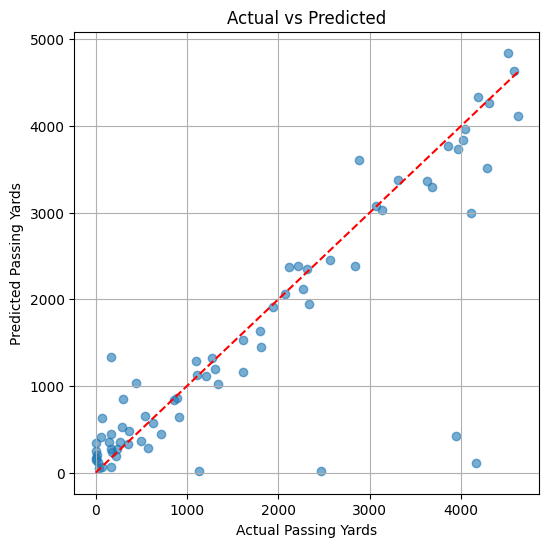

In [201]:
plt.figure(figsize=(6,6))
plt.scatter(actual_vs_pred['Actual'], actual_vs_pred['Predicted'], alpha=0.6)
plt.plot([0, max(actual_vs_pred['Actual'])], [0, max(actual_vs_pred['Actual'])], 'r--')
plt.xlabel("Actual Passing Yards")
plt.ylabel("Predicted Passing Yards")
plt.title("Actual vs Predicted")
plt.grid(True)
plt.show()